This code is deisgned to perform beam characaterizations on the CENER data

Ideas are as below:
1. Use histogram, perform a binary thresholding to identify the background target.
2. Identify the corners on the target, and performs a perspective transform
3. Perform beam analysis, initial step is thresholding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import cv2
from skimage.transform import hough_line, hough_line_peaks


In [2]:

# Load data
data_base_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT"
def list_directories(path):
    return [name for name in os.listdir(path) if os.path.isdir(os.path.join(path, name))]

data_date_folders = list_directories(data_base_folder)
data_format = "*.tif"

data_name_dict = {}

for data_date_folder in data_date_folders:
    data_date_folder = os.path.join(data_base_folder, data_date_folder)
    data_folder = os.path.join(data_date_folder, "images")
    data_files = glob(os.path.join(data_folder, data_format))

    _img_name_list = []
    for _image_name in data_files:
        _img_name_list.append(_image_name)

    data_name_dict[data_date_folder] = _img_name_list

Peak value: 99, Boundary value: 118.8


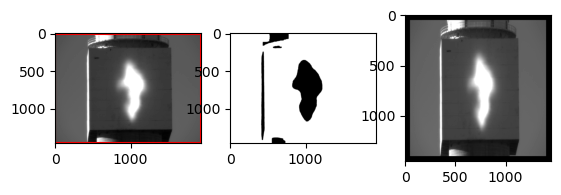

Peak value: 67, Boundary value: 80.39999999999999


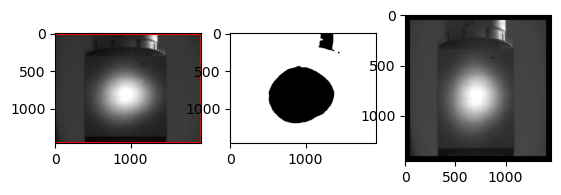

Peak value: 123, Boundary value: 147.6


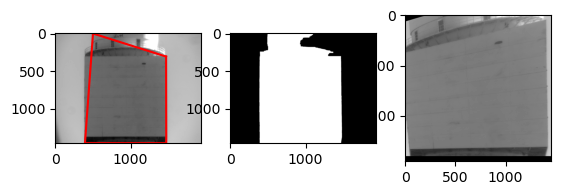

Peak value: 114, Boundary value: 136.79999999999998


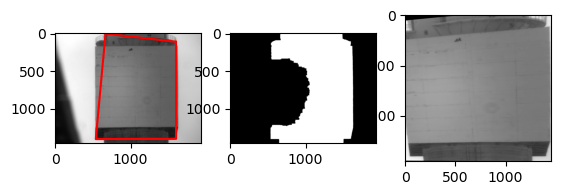

Peak value: 126, Boundary value: 151.2


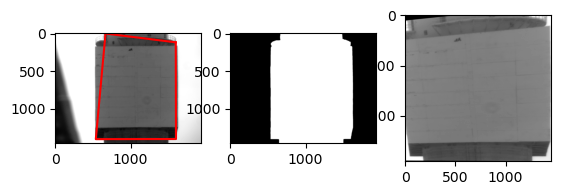

Peak value: 96, Boundary value: 115.19999999999999


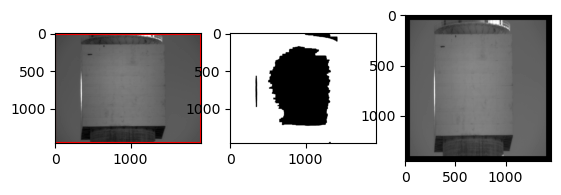

Peak value: 105, Boundary value: 126.0
Target Detection Failed, skipping
Peak value: 177, Boundary value: 212.4


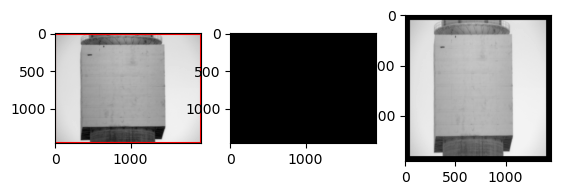

Peak value: 120, Boundary value: 144.0


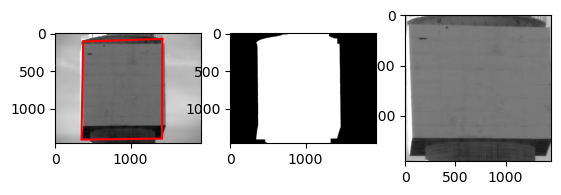

Peak value: 96, Boundary value: 115.19999999999999


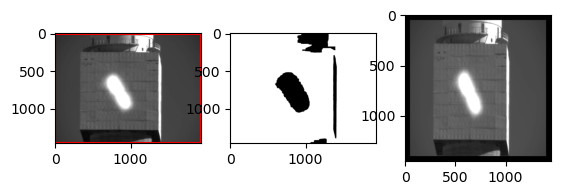

Peak value: 61, Boundary value: 73.2


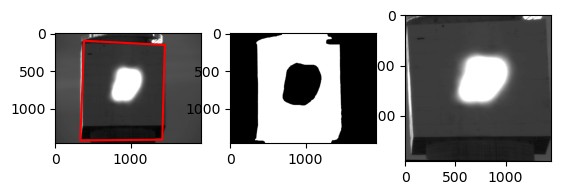

Peak value: 61, Boundary value: 73.2


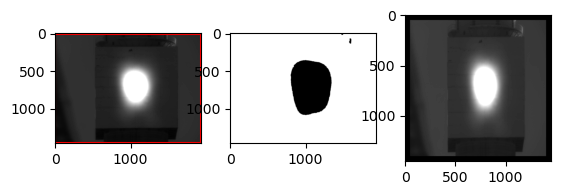

Peak value: 49, Boundary value: 58.8
Target Detection Failed, skipping
Peak value: 58, Boundary value: 69.6


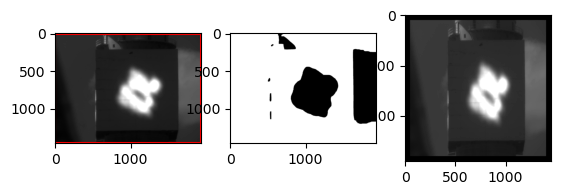

Peak value: 140, Boundary value: 168.0


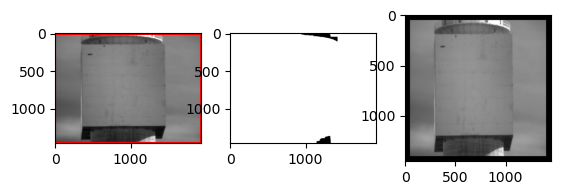

Peak value: 111, Boundary value: 133.2


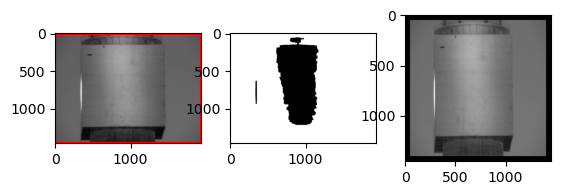

Peak value: 96, Boundary value: 115.19999999999999


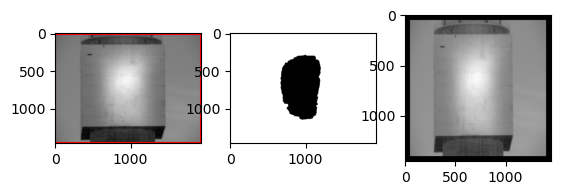

Peak value: 58, Boundary value: 69.6


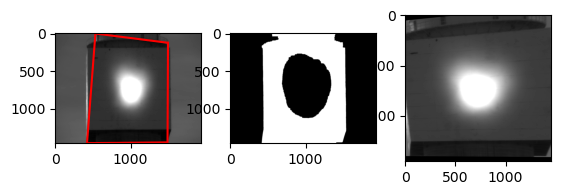

Peak value: 61, Boundary value: 73.2


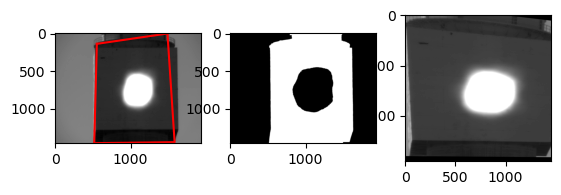

In [13]:
# compare which method can give best results

# data_date_folder = np.random.choice(list(data_name_dict.keys()))    # This gives the data folder
# data_files = data_name_dict[data_date_folder]   # This gives a list of image files in the folder
# data_file = np.random.choice(data_files)

# data_date_folder = r'C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\03_22_2023'
# data_date_folder = r'C:\Users\qzheng\OneDrive - NREL\BCS Comparison\CENER\data\raw_input\raw_input\CAT\04_03_2021\images\Images_1'
# data_files = data_name_dict[data_date_folder]
# data_files = glob(os.path.join(data_date_folder,"*.tif"))

# # crestDume
data_folder = r"Y:\5700\SolarElectric\PROJECTS\38488_HelioCon_Zhu\BeamCharacterizationSystems\CrescentDunes"
data_files = glob(os.path.join(data_folder, "*.bmp"))

for data_file in data_files:

    _img = cv2.imread(data_file, cv2.IMREAD_GRAYSCALE)
    _img_orig = _img.copy()
    bin_width = 1
    # get counts of each pixel value
    hist, bins = np.histogram(_img.ravel(), bins=np.arange(0, 256, bin_width))
    # only keep the first 200 values, over exposure is likely going to cause bad segmentation
    hist_crop = hist[:200]
    # find peak
    peak = np.argmax(hist_crop)
    boundary_value = peak *1.2
    print(f"Peak value: {peak}, Boundary value: {boundary_value}")

# histogram equalization
# _img = cv2.equalizeHist(_img)

# Gaussian adaptive thresholding

    _img_gaussian_adaptive = cv2.adaptiveThreshold(_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 21, 2)
    _img_manual_threshold = cv2.threshold(_img, boundary_value, 255, cv2.THRESH_BINARY)[1]
    # morphological closing
    kernel = np.ones((15, 15), np.uint8)
    _img_manual_threshold = cv2.morphologyEx(_img_manual_threshold, cv2.MORPH_OPEN, kernel)
    kernel = np.ones((15, 100), np.uint8)
    _img_manual_threshold = cv2.morphologyEx(_img_manual_threshold, cv2.MORPH_CLOSE, kernel)

    # invert the manual threshold
    _img_manual_threshold = cv2.bitwise_not(_img_manual_threshold)

    # find largest connected component
    nlabels, labels, stats, centroids = cv2.connectedComponentsWithStats(_img_manual_threshold)
    largest_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1
    _img_manual_threshold = np.zeros_like(_img_manual_threshold)
    _img_manual_threshold[labels == largest_label] = 255

    # trapedoid contour approcimation
    contours, _ = cv2.findContours(_img_manual_threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    epsilon = 0.1 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)

    # perspective transform into a square that spans the entire image
    h, w = _img_manual_threshold.shape
    short_side = min(h, w)
    new_img_shape = (short_side, short_side)


    pts1 = np.float32(approx)
    if pts1.shape[0] != 4:
        print("Target Detection Failed, skipping")
        continue
    margin = 50

    ul = [margin, margin]
    ur = [short_side-margin, margin]
    lr = [short_side-margin, short_side-margin]
    ll = [margin, short_side-margin]
    

    pts2 = np.float32([ul, ll, lr, ur])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    _img_manual_threshold_unwarped = _img_manual_threshold.copy()
    _img_manual_threshold = cv2.warpPerspective(_img_manual_threshold, M, new_img_shape)
    _img_orig = cv2.warpPerspective(_img_orig, M, new_img_shape)
    

    # show the original and new
    plt.figure()
    plt.subplot(131)
    plt.imshow(_img, cmap='gray')
    # plot the contour
    plt.plot(approx[:, 0, 0], approx[:, 0, 1], 'r')
    plt.plot([approx[-1, 0, 0], approx[0, 0, 0]], [approx[-1, 0, 1], approx[0, 0, 1]], 'r')
    plt.subplot(132)
    plt.imshow(_img_manual_threshold_unwarped, cmap='gray')
    plt.subplot(133)
    # histogram equalization of the transformed image
    # _img_orig = cv2.equalizeHist(_img_orig)
    plt.imshow(_img_orig, cmap='gray')

    plt.show()



In [ ]:
imageFiles = sorted(glob("Y:/5700/SolarElectric/PROJECTS/38488_HelioCon_Zhu/BeamCharacterizationSystems/CrescentDunes/*.bmp"),key=len)

print()


In [ ]:
# do a morphological opening
kernel = np.ones((5,5),np.uint8)
opening = cv2.morphologyEx(_img_otsu, cv2.MORPH_OPEN, kernel)

blurred_image = cv2.GaussianBlur(opening, (5, 5), 0)

# Apply the Laplacian operator on the blurred image
laplacian = cv2.Laplacian(blurred_image, cv2.CV_64F)

# Convert the Laplacian result to uint8 (normal image format) for visualization
laplacian = np.uint8(np.absolute(laplacian))

# Display the Laplacian of Gaussian result using matplotlib
plt.figure(figsize=(8, 8))  # Optionally, set the figure size
plt.imshow(laplacian, cmap='gray')  # Display in grayscale
plt.title('Laplacian of Gaussian (LoG) Edge Detection')
plt.axis('off')  # Hide axes
plt.show()
